In [2]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [3]:
blacklist = [180] # emoid: 180; rest: 220,233,274,284,472

subids = [_id for _id in meta if 'nback' in meta[_id] 
          and 'emoid' in meta[_id] and int(meta[_id]['emoid']) not in [180]] 

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subids]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subids]

print('Loading complete')
print(len(nback_ts))
print(len(emoid_ts))

Loading complete
650
650


In [16]:
# Convert to pytorch
# Split into train and test

import numpy as np
import torch

nTrain = 580

def makePoly(np, order):
    nps = [np]
    for i in range(order-1):
        nps.append(nps[-1]*np)
    return torch.cat(nps,dim=1)

nback_p_t = torch.from_numpy(np.stack([np.corrcoef(ts).flatten() for ts in nback_ts])).float()
emoid_p_t = torch.from_numpy(np.stack([np.corrcoef(ts).flatten() for ts in emoid_ts])).float()

# nback_p_t = makePoly(nback_p_t,3)
# emoid_p_t = makePoly(emoid_p_t,3)

perm = torch.randperm(nback_p_t.shape[0])
trainIdx = perm[:nTrain]
testIdx = perm[nTrain:]

nback_p_t_train = nback_p_t[trainIdx].cuda()
nback_p_t_test = nback_p_t[testIdx].cuda()

emoid_p_t_train = emoid_p_t[trainIdx].cuda()
emoid_p_t_test = emoid_p_t[testIdx].cuda()

print(nback_p_t.shape)
print(nback_p_t_train.shape)
print(nback_p_t_test.shape)

print(emoid_p_t.shape)
print(emoid_p_t_train.shape)
print(emoid_p_t_test.shape)

torch.Size([650, 69696])
torch.Size([580, 69696])
torch.Size([70, 69696])
torch.Size([650, 69696])
torch.Size([580, 69696])
torch.Size([70, 69696])


In [17]:
# Ages

ages = []

for _id in meta:
    if 'nback' in meta[_id] and 'emoid' in meta[_id] and int(meta[_id]['emoid']) not in [180]:
        ages.append(meta[_id]['meta']['AgeInMonths']/12)

ages = torch.tensor(ages).float()
ages_train = ages[trainIdx].cuda()
ages_test = ages[testIdx].cuda()

print(ages.shape)
print(ages_train.shape)
print(ages_test.shape)

torch.Size([650])
torch.Size([580])
torch.Size([70])


In [18]:
import torch.nn as nn
import torch.nn.functional as F
import itertools
import random
import copy

nConnEdge = nback_p_t.shape[1]

class DiffGraph(nn.Module):
    def __init__(self):
        super(DiffGraph, self).__init__()
        self.fc1 = nn.Linear(4*nConnEdge,1).float().cuda()
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    
dg = DiffGraph()
optim = torch.optim.Adam(dg.parameters(), lr=1e-5, weight_decay=0.2)

nEpoch = 10
bSize = 1000
pPeriod = 10000

pairs = list(itertools.combinations_with_replacement(np.arange(nTrain),2))

for i in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {i}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A1 = nback_p_t_train[Ai,:]
        A2 = emoid_p_t_train[Ai,:]
        B1 = nback_p_t_train[Bi,:]
        B2 = nback_p_t_train[Bi,:]
        a = ages_train[list(Ai)]
        b = ages_train[list(Bi)]
        optim.zero_grad()
        pos = torch.cat([A1,A2,B1,B2],dim=1)
        neg = torch.cat([B1,B2,A1,A2],dim=1)
        posRes = dg(pos).flatten()
        negRes = dg(neg).flatten()
        posLoss = torch.mean((posRes-(a-b))**2)**0.5
        negLoss = torch.mean((negRes-(b-a))**2)**0.5
        (posLoss+negLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0:
            print(f'\tposLoss={posLoss} negLoss={negLoss} complete={nComplete}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=4.589054584503174 negLoss=4.604941368103027 complete=0
	posLoss=4.409933567047119 negLoss=4.398806095123291 complete=10000
	posLoss=4.342199802398682 negLoss=4.342113971710205 complete=20000
	posLoss=4.029332637786865 negLoss=4.038797378540039 complete=30000
	posLoss=3.930035352706909 negLoss=3.933579683303833 complete=40000
	posLoss=4.021901607513428 negLoss=4.025534629821777 complete=50000
	posLoss=3.5748610496520996 negLoss=3.5763044357299805 complete=60000
	posLoss=3.5996811389923096 negLoss=3.6127805709838867 complete=70000
	posLoss=3.7174201011657715 negLoss=3.719237804412842 complete=80000
	posLoss=3.510512590408325 negLoss=3.50844144821167 complete=90000
	posLoss=3.440521240234375 negLoss=3.442333459854126 complete=100000
	posLoss=3.2999210357666016 negLoss=3.3014535903930664 complete=110000
	posLoss=3.191068649291992 negLoss=3.189735174179077 complete=120000
	posLoss=3.124992609024048 negLoss=3.118750810623169 complete=130000
	posLoss=3.1137735843658447 negLos

	posLoss=0.44799137115478516 negLoss=0.4428953230381012 complete=150000
	posLoss=0.42790642380714417 negLoss=0.4246857762336731 complete=160000
epoch 7
	posLoss=0.3995773494243622 negLoss=0.39630311727523804 complete=0
	posLoss=0.4192197620868683 negLoss=0.41560983657836914 complete=10000
	posLoss=0.4387226700782776 negLoss=0.43638795614242554 complete=20000
	posLoss=0.4153881371021271 negLoss=0.41041260957717896 complete=30000
	posLoss=0.4230382442474365 negLoss=0.4247679114341736 complete=40000
	posLoss=0.43649822473526 negLoss=0.4389660358428955 complete=50000
	posLoss=0.40079158544540405 negLoss=0.39912593364715576 complete=60000
	posLoss=0.4054468870162964 negLoss=0.404109925031662 complete=70000
	posLoss=0.3814094364643097 negLoss=0.3784663677215576 complete=80000
	posLoss=0.39297178387641907 negLoss=0.3847721815109253 complete=90000
	posLoss=0.3879511058330536 negLoss=0.38216567039489746 complete=100000
	posLoss=0.3799022138118744 negLoss=0.3752027750015259 complete=110000
	posL

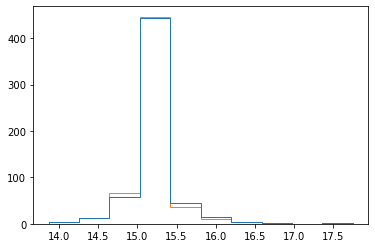

tensor(18., device='cuda:0')


In [19]:
# Test 1 subject

import matplotlib.pyplot as plt

idx = 3

A1 = nback_p_t_test[idx].expand(nTrain,-1)
A2 = emoid_p_t_test[idx].expand(nTrain,-1)
a = ages_test[idx].expand(nTrain)

B1 = nback_p_t_train
B2 = emoid_p_t_train
b = ages_train

pos = torch.cat([A1,A2,B1,B2],dim=1)
neg = torch.cat([B1,B2,A1,A2],dim=1)
posRes = dg(pos).flatten()
negRes = dg(neg).flatten()

agePos = posRes + b
ageNeg = b - negRes

ap = agePos.detach().cpu().numpy()
an = ageNeg.detach().cpu().numpy()

plt.hist([ap, an], histtype='step')
plt.show()

print(a[0])

done 0
done 20
done 40
done 60
Positive
[[1.         0.83947199]
 [0.83947199 1.        ]]
1.672044886615351
1.4079448018755232
Negative
[[1.         0.83706517]
 [0.83706517 1.        ]]
1.6796967074392635
1.4176185880388532
Mean
[[1.         0.83833893]
 [0.83833893 1.        ]]
1.6755020288703728
1.4127816949571883
Least squares
[[1.         0.78524622]
 [0.78524622 1.        ]]
1.9161093841539545
1.5860564


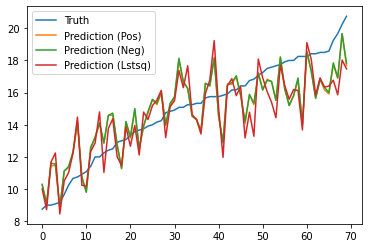

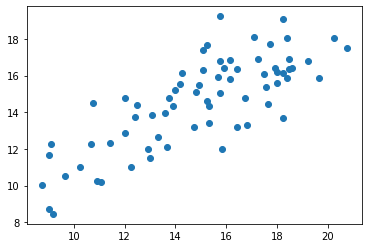

In [20]:
# Test

ap = np.zeros(len(testIdx))
an = np.zeros(len(testIdx))

for i in range(nback_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
        
    A1 = nback_p_t_test[i].expand(nTrain,-1)
    A2 = emoid_p_t_test[i].expand(nTrain,-1)
    a = ages_test[i].expand(nTrain)

    B1 = nback_p_t_train
    B2 = emoid_p_t_train
    b = ages_train

    pos = torch.cat([A1,A2,B1,B2],dim=1)
    neg = torch.cat([B1,B2,A1,A2],dim=1)
    posRes = dg(pos).flatten()
    negRes = dg(neg).flatten()

    agePos = posRes + b
    ageNeg = b - negRes

    ap[i] = torch.mean(agePos).detach().cpu().numpy()
    an[i] = torch.mean(ageNeg).detach().cpu().numpy()

# pred = gat(rest_ts_t_test)
# pred = pred.flatten().detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
ap = ap[idcs]
an = an[idcs]
am = (ap+an)/2
y = y[idcs]

print('Positive')

corr = np.corrcoef(y, ap)
rmse = np.mean((y-ap)**2)**0.5
mae = np.mean(np.abs(y-ap))

print(corr)
print(rmse)
print(mae)

print('Negative')

corr = np.corrcoef(y, an)
rmse = np.mean((y-an)**2)**0.5
mae = np.mean(np.abs(y-an))

print(corr)
print(rmse)
print(mae)

print('Mean')

corr = np.corrcoef(y, am)
rmse = np.mean((y-am)**2)**0.5
mae = np.mean(np.abs(y-am))

print(corr)
print(rmse)
print(mae)

w,_,_,_ = torch.linalg.lstsq(torch.cat([nback_p_t_train,emoid_p_t_train],dim=1),ages_train)

a = torch.cat([nback_p_t_test,emoid_p_t_test],dim=1)@w
a = a.detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
a = a[idcs]
y = y[idcs]

print('Least squares')

corr = np.corrcoef(y, a)
rmse = np.mean((y-a)**2)**0.5
mae = np.mean(np.abs(y-a))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(ap, label='Prediction (Pos)')
plt.plot(an, label='Prediction (Neg)')
plt.plot(a, label='Prediction (Lstsq)')
plt.legend()
plt.show()

plt.scatter(y, a)
plt.show()

In [25]:
ep = np.zeros([nTrain,nTrain])
en = np.zeros([nTrain,nTrain])

bSize = 100

for i in range(nback_p_t_train.shape[0]):
    
    nComplete = 0
    while nComplete < nTrain:
        todo = nTrain-nComplete
        if todo > bSize:
            todo = bSize
        
        A1 = nback_p_t_train[i].expand(todo,-1)
        A2 = emoid_p_t_train[i].expand(todo,-1)
        a = ages_train[i].expand(todo)

        B1 = nback_p_t_train[nComplete:nComplete+todo]
        B2 = emoid_p_t_train[nComplete:nComplete+todo]
        b = ages_train[nComplete:nComplete+todo]

        pos = torch.cat([A1,A2,B1,B2],dim=1)
        neg = torch.cat([B1,B2,A1,A2],dim=1)
        posRes = (dg(pos).flatten()-(a-b)).detach().cpu().numpy()
        negRes = (dg(neg).flatten()-(b-a)).detach().cpu().numpy()
        
        optim.zero_grad()

        ep[i,nComplete:nComplete+todo] = posRes
        en[i,nComplete:nComplete+todo] = negRes
    
        nComplete += todo
        
    if i % 50 == 0:
        print(f'done {i}')
    
print('Complete')

done 0
done 50
done 100
done 150
done 200
done 250
done 300
done 350
done 400
done 450
done 500
done 550
Complete


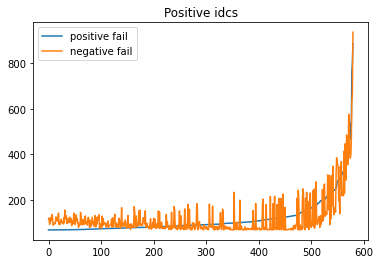

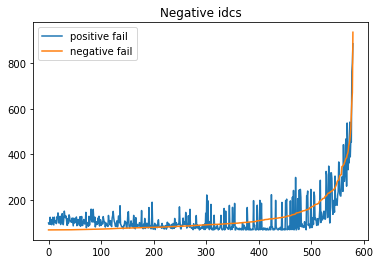

In [26]:
errP = np.sum(np.abs(ep),axis=0)
errN = np.sum(np.abs(en),axis=0)

idcsP = np.argsort(errP)
plt.plot(errP[idcsP],label='positive fail')
plt.plot(errN[idcsP],label='negative fail')
plt.legend()
plt.title('Positive idcs')
plt.show()

idcsN = np.argsort(errN)
plt.plot(errP[idcsN],label='positive fail')
plt.plot(errN[idcsN],label='negative fail')
plt.legend()
plt.title('Negative idcs')
plt.show()

In [23]:
# Test whether each "half" of the model is just calculating age...
        
A1 = nback_p_t_test
A2 = emoid_p_t_test
a = ages_test

feat = torch.cat([A1,A2],dim=1)
ap = (feat@(dg.fc1.weight.T[0:2*nConnEdge])).detach().flatten().cpu().numpy()
an = (feat@(dg.fc1.weight.T[2*nConnEdge:])).detach().flatten().cpu().numpy()

In [24]:
print(ap)

[-3.9994195e+00 -2.9360106e+00 -7.4545569e+00 -2.9587815e+00
 -1.6605239e+00 -6.9307909e+00 -3.2632837e+00 -1.2878835e+00
 -2.3714223e+00  3.4677064e-01 -4.1940389e+00 -1.3300239e+00
 -5.2521033e+00  6.6557527e-04  1.4773754e+00 -9.3378105e+00
 -7.0454288e+00 -2.3887401e+00 -6.7138176e+00 -1.5086640e+00
 -6.8632507e+00 -9.0726690e+00 -2.0000181e+00 -2.5045319e+00
 -1.6469177e+00 -5.4918528e-03 -8.4000593e-01 -4.2390547e+00
 -2.6370306e+00 -3.6620152e+00 -8.3521395e+00 -3.4195974e+00
 -2.2636886e+00 -1.5277442e+00 -3.6619051e+00 -3.8357801e+00
 -4.9784815e-01 -1.7432914e+00 -1.3944836e+00 -5.6943769e+00
 -4.9274898e+00 -2.9306750e+00 -3.5707545e+00 -5.3220558e+00
 -1.1906965e+00 -3.6235218e+00 -2.5181353e+00 -4.1031256e+00
 -5.6150980e+00 -2.2948825e+00 -9.2306912e-01 -5.9485803e+00
 -4.5457325e+00 -4.9992881e+00 -4.0936346e+00 -4.2918215e+00
 -1.3496220e+00 -6.7276769e+00 -1.3104749e-01 -1.9282398e+00
 -2.0014293e+00 -7.9384756e+00 -4.1459155e+00 -1.5993046e+00
 -3.0006299e+00 -2.00866

In [25]:
print(an)

[ 4.002638    2.8671267   7.4398427   3.0184102   1.5868872   6.9051905
  3.1912274   1.2803277   2.3687687  -0.35895693  4.1526504   1.4068382
  5.312274    0.08012775 -1.4634862   9.349366    7.0834675   2.3801262
  6.650169    1.5015126   6.7949095   9.116478    1.9552181   2.462277
  1.7256129  -0.01675829  0.8610269   4.19878     2.6207201   3.6510751
  8.4024515   3.3754156   2.2049167   1.5251195   3.6512995   3.8923
  0.3867744   1.792099    1.2934995   5.6111283   5.00206     2.8690846
  3.4782767   5.338763    1.1603817   3.6208675   2.5581589   3.9837034
  5.7152557   2.3269281   1.0243747   5.8673224   4.596298    4.96644
  3.9758844   4.266554    1.4357065   6.59311     0.06915273  1.9487572
  2.041794    7.906702    4.0863686   1.6365352   2.8707268   1.8757174
  2.6902733   2.1517575   5.4544964   0.34815127]


In [26]:
print(an-ap)

[ 8.0020571e+00  5.8031373e+00  1.4894400e+01  5.9771919e+00
  3.2474113e+00  1.3835981e+01  6.4545112e+00  2.5682111e+00
  4.7401910e+00 -7.0572758e-01  8.3466892e+00  2.7368622e+00
  1.0564377e+01  7.9462171e-02 -2.9408617e+00  1.8687176e+01
  1.4128897e+01  4.7688665e+00  1.3363987e+01  3.0101767e+00
  1.3658160e+01  1.8189148e+01  3.9552362e+00  4.9668088e+00
  3.3725305e+00 -1.1266440e-02  1.7010329e+00  8.4378347e+00
  5.2577505e+00  7.3130903e+00  1.6754591e+01  6.7950130e+00
  4.4686050e+00  3.0528636e+00  7.3132048e+00  7.7280798e+00
  8.8462257e-01  3.5353904e+00  2.6879830e+00  1.1305506e+01
  9.9295502e+00  5.7997599e+00  7.0490313e+00  1.0660819e+01
  2.3510780e+00  7.2443895e+00  5.0762939e+00  8.0868292e+00
  1.1330354e+01  4.6218109e+00  1.9474438e+00  1.1815903e+01
  9.1420307e+00  9.9657288e+00  8.0695190e+00  8.5583754e+00
  2.7853284e+00  1.3320787e+01  2.0020021e-01  3.8769970e+00
  4.0432234e+00  1.5845178e+01  8.2322845e+00  3.2358398e+00
  5.8713570e+00  3.88438

In [27]:
print(dg.fc1.bias)

Parameter containing:
tensor([-0.0008], device='cuda:0', requires_grad=True)
